In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vpn-classification/dataset_v2/shodan_df_hashed.csv
/kaggle/input/vpn-classification/dataset_v2/test.parq
/kaggle/input/vpn-classification/dataset_v2/train.parq
/kaggle/input/vpn-classification/dataset_v2/samples_submissions.csv
/kaggle/input/vpn-classification/dataset_v2/train.csv
/kaggle/input/vpn-classification/dataset_v2/test.csv


In [2]:
import ast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Introduction

## Goal

The goal of this competition is to identify users of annoymization services (proxies, VPNs) by analyzing the abuse patterns coming from their associated ips.


## Dataset

The dataset included in this competition is a slice of signals we receive from crowdsec security engines installed all over the world. Each line is a security engine detecting an attack using one of our many scenarios. Each line contains three different sections of data. 

* Information about the security engine (called watcher) reporting the attack
* Information about the ip (called attacker) doing the attack
* Information about the attack itself

Data about the security engine can be found in the columns `watcher_country, watcher_as_num, watcher_as_name, watcher_uuid_enum`  
Data about the attacker can be found in the columns `attacker_country, attacker_as_num, attacker_as_name, attacker_ip_enum`  
Data about the attack can be found in the columns `attack_time, attack_type`

Additionally, you can find the results of portscans and respective service hashes in `shodan_info_hashed.csv`. Note that this dataset contains information about attacker IPs in both train and test set.

### CSV format

In [3]:
#dtypes = {
#    # 'attack_time': 'datetime64[ns]',
#    "watcher_country": "object",
#    "watcher_as_num": "float32",
#    "watcher_as_name": "object",
#    "attacker_country": "category",
#    "attacker_as_num": "float32",
#    "attacker_as_name": "object",
#    "attack_type": "category",
#    "watcher_uuid_enum": "int32",
#    "attacker_ip_enum": "int32",
#    "label": "int8",
#}

#df = pd.read_csv("/kaggle/input/vpn-classification/dataset_v2/train.csv", dtype=dtypes, parse_dates=["attack_time"])
#df.dtypes
#df.head()

### Parquet format

Alternatively you can use parquet format, which loads significantly faster.

In [4]:
df = pd.read_parquet("/kaggle/input/vpn-classification/dataset_v2/train.parq")
df.dtypes
df.head()

,attack_time,watcher_country,watcher_as_num,watcher_as_name,attacker_country,attacker_as_num,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum,label
0,2023-07-31 07:17:51+00:00,DE,34011.0,Host Europe GmbH,TR,47721.0,Murat Aktas,http:exploit,0,6466,0
1,2023-07-31 07:17:51+00:00,DE,34011.0,Host Europe GmbH,TR,47721.0,Murat Aktas,http:spam,0,6466,0
2,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:bruteforce,2,4637,0
3,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:spam,2,4637,0
4,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:exploit,2,4637,0


# Useful concepts

This section serves to explain some useful concepts to people unfamilliar with networks and security topics. 

## AS (Autonomous systems)

The dataset contains AS information for both the attacker and the security engine. An autonomous system is a top-level owner of an IP address. For end users it is usually the internet service provider. If you host an instance somewhere in the cloud, the IP is usually owned by the hoster itself (DIGITALOCEAN, AMAZON AWS, GOOGLE CLOUD, HETZNER etc.). Every AS can be identified by a unique number, which then can be used to find more information about it on internet. A convenient website such as IP Info easily provide complementary information of a given AS based on its number: [AS1406](https://ipinfo.io/AS1406)

IPs belonging to the same AS can present the same specificities in terms of attack types and patterns. Some AS are also more likely to host VPN IPs than others. 
The ASN could for instance be used to compute trust scores for watchers or attackers as not all hosters are equally vigilant with cleaning up malicious actors.

## Attack Description

The `attack_type` column contains information about the attack that was detected, e.g. `ssh:bruteforce`. It is split into two parts of information: the attack service (http, ssh, windows etc.) and the attack type (bruteforce, exploit, spam etc.). You may find the full list in the [Behavior section of CrowdSec CTI Documentation](https://docs.crowdsec.net/docs/next/cti_api/taxonomy/#behaviors)

The attack service is mostly self-explanatory with a lot of common known protocols. `http` is for web based attacks, `ssh` for secure shell (remote login for linux basically) `windows` is the umbrella category for all attacks that are detected in windows logs, `tcp` is for network attacks that operate below the `http` layer. There are a few rare ones, `pop3/imap` collects attacks targeting mail servers and `sip` collects attacks targeting VoIP (internet telephone).  

The attack type covers the basic [MITRE](https://attack.mitre.org/) classifications of cyber attacks. `bruteforce` covers attacks with work through enumeration (trying passwords at random for instance), `exploit` covers attacks that abuse specific vulnerabilities in software like [log4shell](https://en.wikipedia.org/wiki/Log4Shell), `spam` covers spamming attacks, usually directed at some form (input field) on a website, `scan` covers attacks that try to detected services and open ports, usually as reconnaissance for more targeted attacks and `crawl` is refers to attacks the try to generate sitemaps and the like on the http layer. 

The scenario information can for instance be used as a feature directly to separate different types of annonymization services. Importantly, proxies can only be used at the HTTP layer, so a proxy IP is not supposed to be reported for SSH attacks.
Another way of using the attack type can be to group watchers by the kind of services they expose. 

## Shodan info

There is an additional dataset that comes with our trainset called `shodan_info_hashed`. The `shodan_info` column contains data we enrich from the third-party threat intelligence provider [shodan.io](https://www.shodan.io/). The column contains a dictionary that contains the open ports of a given attacker and the protocol these ports support.  
For instance take the following example: 
```
{'443/tcp': {'headers_hash': -1035061394,
  'jarm': '2ad2ad16d00000022c2ad2ad2ad2adbc07bc352a188303b518c8a273c71220',
  'ja3s': '986571066668055ae9481cb84fda634a'}}
```
The key `443/tcp` tells us that this attacker has port `443` open and accessible using `tcp`. For most ports there are conventions on what services are usually found on it. [Wikipedia](https://en.wikipedia.org/wiki/List_of_TCP_and_UDP_port_numbers) has a good list. If the port in question supports `http` we include a `headers_hash` which is a somewhat unique fingerprint. For connections that support `ssl` we include the `jarm` and `ja3s` which both offer ways to fingerprint specific device configurations, and can certainly be useful for the challenge.


## Viz

We plot the distribution of attack types and the label. The dataset is highly imbalanced

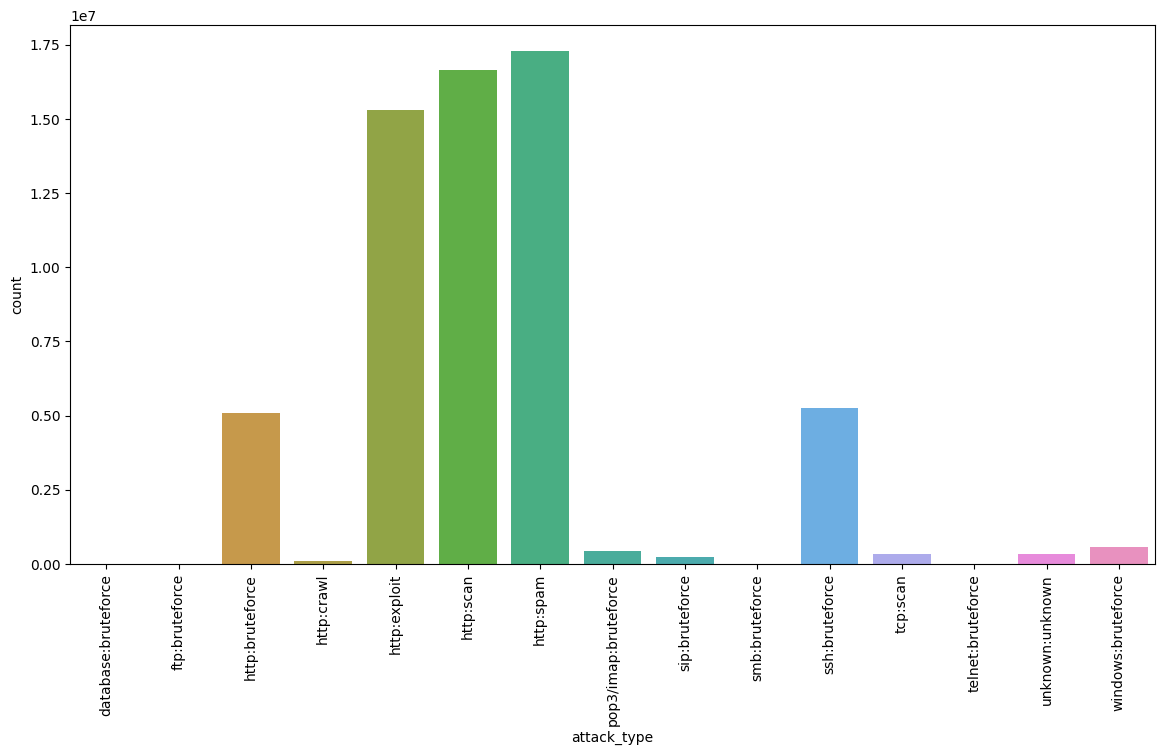

In [5]:
_ = plt.figure(figsize=(14, 7))
_ = sns.countplot(x=df["attack_type"])
_ = plt.xticks(rotation=90)
plt.show()

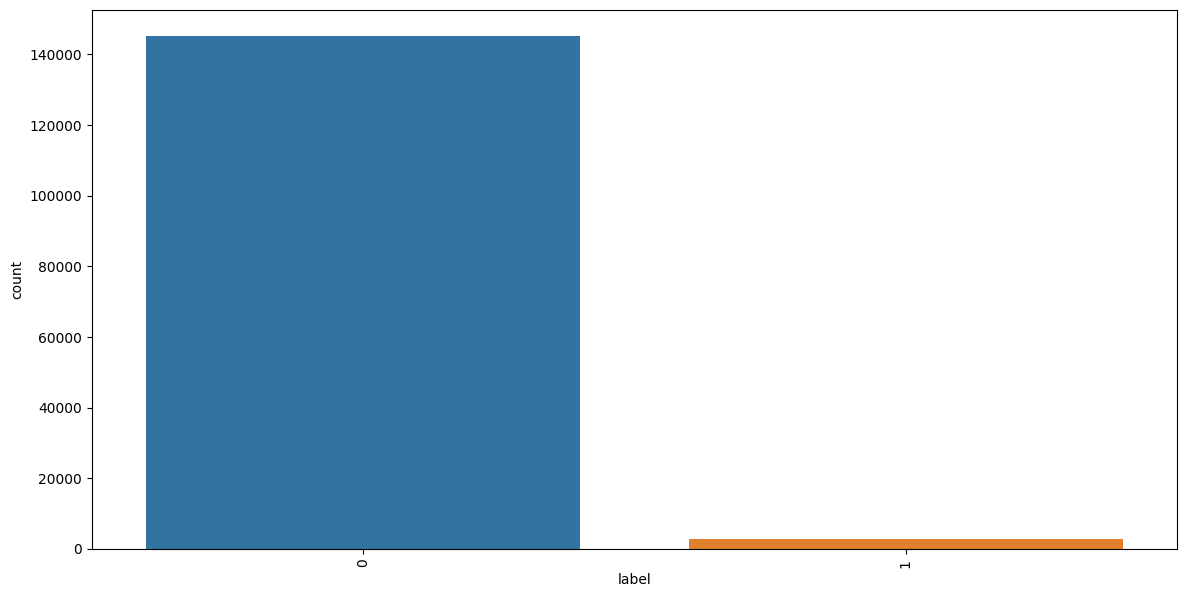

In [6]:
_ = plt.figure(figsize=(14, 7))
# Counting the number of labels for each IP (hence the groupby)
_ = sns.countplot(x=df.groupby("attacker_ip_enum")["label"].max())
_ = plt.xticks(rotation=90)
plt.show()

# Basic Model

We train a very simple RandomForestClassifier on the dataset using a standard train-test split to verify the results. 

As the prediction is on a per-attacker basis, we build features using pandas groupby and aggregation operations.

## Feature Engineering

As features we use:

* a one-hot encoding of the attack service
* a one-hot encoding of the attack type (normalized)
* a one-hot encoding of some of the most common ports
* total number of open ports

### One-hot attack types
We first split the `attack_type` into `service` and `type` and use `pd.get_dummies()`

In [7]:
attack_types_df = (
    df.attack_type.str.split(":", expand=True)
    .rename(columns={0: "service", 1: "type"})
    .set_index(df["attacker_ip_enum"])
)

In [8]:
one_hot_attack_service_df = pd.get_dummies(
    # Dropping duplicated service before calling get dummies
    attack_types_df.reset_index()
    .drop_duplicates(subset=["attacker_ip_enum", "service"])
    .set_index("attacker_ip_enum")["service"]
    # ,sparse=True
)
one_hot_attack_service_df = one_hot_attack_service_df.groupby("attacker_ip_enum").sum()
# We group by ip_enum and keep only strictly positive values
one_hot_attack_service_df = (one_hot_attack_service_df >= 1).astype(int)
one_hot_attack_service_df.head()

,database,ftp,http,pop3/imap,sip,smb,ssh,tcp,telnet,unknown,windows
attacker_ip_enum,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [9]:
one_hot_attack_types_df = pd.get_dummies(
    attack_types_df["type"],
    # sparse=True
)
one_hot_attack_types_df = one_hot_attack_types_df.groupby("attacker_ip_enum").sum()
# We group by ip_enum and normalized by the number of attack to get a distribyution
one_hot_attack_types_df = one_hot_attack_types_df / one_hot_attack_types_df.sum(
    1
).values.reshape(-1, 1)
one_hot_attack_types_df.head(10)

,bruteforce,crawl,exploit,scan,spam,unknown
attacker_ip_enum,,,,,,
0,0.000000,0.0,0.000000,0.500000,0.500000,0.0
1,0.266667,0.0,0.466667,0.033333,0.233333,0.0
2,0.000000,0.0,0.000000,0.931034,0.068966,0.0
3,0.080000,0.0,0.600000,0.040000,0.280000,0.0
4,0.235294,0.0,0.455882,0.058824,0.250000,0.0
6,0.000000,0.0,0.021739,0.847826,0.130435,0.0
8,0.235294,0.0,0.470588,0.058824,0.235294,0.0
9,0.250000,0.0,0.500000,0.000000,0.250000,0.0
11,0.006250,0.0,0.006250,0.793750,0.193750,0.0


### Open ports Feature

As the port information is collected on a per-attacker basis we only have one row per attacker IP, so we don't need to use `pd.groupby()` this time.

In [10]:
REFERENCE_PORTS = set(("22", "80", "443", "7777"))


def extract_port_numbers(value: dict):
    return set(key.split("/")[0] for key in value.keys())


shodan_df = pd.read_csv(
    "/kaggle/input/vpn-classification/dataset_v2/shodan_df_hashed.csv",
    dtype={"attacker_ip_enum": "int32"},
    index_col="attacker_ip_enum",
)
shodan_df["shodan_info"] = shodan_df["shodan_info"].map(ast.literal_eval)
shodan_df["shodan_open_ports"] = shodan_df["shodan_info"].map(extract_port_numbers)

In [11]:
open_ports_count = shodan_df["shodan_open_ports"].map(len).rename("open_ports_count")
# We select the reference port by doing a set intersection
reference_ports_df = shodan_df["shodan_open_ports"].map(lambda x: REFERENCE_PORTS & x)

one_hot_reference_ports_df = pd.get_dummies(reference_ports_df.explode(), prefix="port")
# Aggregate the dummies by IP
one_hot_reference_ports_df = one_hot_reference_ports_df.groupby(
    "attacker_ip_enum"
).sum()
# Final feature for port: count and one hot table of reference port
ports_features_df = pd.concat([one_hot_reference_ports_df, open_ports_count], axis=1)
# Checking results
ports_features_df[(ports_features_df > 0).any(axis=1)].head()

,port_22,port_443,port_7777,port_80,open_ports_count
attacker_ip_enum,,,,,
5,0,0,0,1,2
7,1,1,0,1,6
13,0,0,0,1,6
18,1,0,0,0,1
24,0,1,0,1,15


### Feature Aggregation

We merge our engineered features together with the labels from the `label` column to get a tabular dataset with can start training on. Note that we use `join="inner"` because  `ports_df` also includes the attackers in the test set (leaderboard)

In [12]:
# We create a df label df which contains one row per attacker IP
label_df = df.drop_duplicates(["attacker_ip_enum", "label"]).set_index(
    "attacker_ip_enum"
)["label"]

dataset = pd.concat(
    [
        one_hot_attack_types_df,
        one_hot_attack_service_df,
        ports_features_df,
        label_df,
    ],
    axis=1,
    join="inner",
)

## Upsampling and Downsampling

Something needs to be done to address the label imbalance. There is a lot of literature on how to address labeling imbalance, so pick your poison.  

In the test set for the leaderboard this is addressed by the F1 scoring that we used. This is to ensure that we have proper data to predict and that the leaderboard cannot be gamed by models which simply predict 0 for every label. 

For the demo we opted to use a RandomForest without any up or downsamplig, but we have included code to show an example of the two approaches just in case.


In [13]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

In [14]:
train, test = train_test_split(dataset, test_size=0.3)

In [15]:
X_train_raw = train.drop(["label"], axis=1)
y_train_raw = train["label"]
X_test_raw = test.drop(["label"], axis=1)
y_test_raw = test["label"]

In [16]:
# under = RandomUnderSampler(replacement=False)
# over = ADASYN(n_neighbors = 10, n_jobs=-1)

In [17]:
# X_train, y_train = over.fit_resample(X_train_raw, y_train_raw)
# X_test, y_test = under.fit_resample(X_test_raw, y_test_raw)

In [18]:
X_train, y_train = X_train_raw, y_train_raw
X_test, y_test = X_test_raw, y_test_raw

## Model training

We train a very simple random forest model and optimize the hyperparameters over a grid search.  

Depending on the model used, you might have to do some standardization to get nice convergence. For decision tree based models this is not required as it the scale of the axes does not impact the discrete decision boundaries. We nonetheless add it as a demonstration.

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [22]:
parameters = {
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", None],
    "class_weight": ["balanced", None],
}
est = RandomForestClassifier()
clf = GridSearchCV(est, parameters, scoring="f1", n_jobs=-1)

In [23]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', None]},
             scoring='f1')

In [24]:
clf.best_params_

{'class_weight': None, 'max_depth': 20, 'max_features': None}

In [25]:
pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,35.073008,5.994679,0.306540,0.070842,None,20,None,"{'class_weight': None, 'max_depth': 20, 'max_f...",0.607092,0.631732,0.624460,0.617486,0.572246,0.610603,0.020830,1
7,37.860273,1.580615,0.325758,0.027791,None,None,None,"{'class_weight': None, 'max_depth': None, 'max...",0.621083,0.630970,0.608187,0.609756,0.567760,0.607551,0.021541,2
6,11.110594,1.055794,0.379837,0.039634,None,None,sqrt,"{'class_weight': None, 'max_depth': None, 'max...",0.598820,0.619048,0.602410,0.617524,0.592486,0.606057,0.010489,3
10,12.661101,0.760097,0.372627,0.030859,None,20,sqrt,"{'class_weight': None, 'max_depth': 20, 'max_f...",0.614243,0.615156,0.596386,0.617564,0.580645,0.604799,0.014238,4
9,33.506010,2.518090,0.276834,0.024883,None,10,None,"{'class_weight': None, 'max_depth': 10, 'max_f...",0.600897,0.607634,0.596006,0.603175,0.583459,0.598234,0.008284,5
4,10.644169,0.762248,0.381928,0.030330,balanced,20,sqrt,"{'class_weight': 'balanced', 'max_depth': 20, ...",0.491286,0.478732,0.491379,0.491915,0.483444,0.487351,0.005331,6
5,31.965864,1.667111,0.322236,0.026268,balanced,20,None,"{'class_weight': 'balanced', 'max_depth': 20, ...",0.480929,0.475800,0.489307,0.495948,0.491859,0.486769,0.007363,7
8,9.435780,0.747660,0.279269,0.012813,None,10,sqrt,"{'class_weight': None, 'max_depth': 10, 'max_f...",0.512648,0.502618,0.492091,0.468376,0.432337,0.481614,0.028696,8
0,10.304630,0.450861,0.341550,0.005059,balanced,None,sqrt,"{'class_weight': 'balanced', 'max_depth': None...",0.472425,0.462000,0.451411,0.479125,0.473251,0.467642,0.009813,9
1,32.646021,2.281473,0.311103,0.021103,balanced,None,None,"{'class_weight': 'balanced', 'max_depth': None...",0.454277,0.454452,0.451020,0.476465,0.457203,0.458684,0.009104,10


In [26]:
y_pred = clf.predict(X_test)

In [27]:
f1_score(y_pred=y_pred, y_true=y_test)

0.5964263709180528

In [28]:
model = RandomForestClassifier(n_jobs=-1, **clf.best_params_)
model.fit(sc.transform(dataset.drop(["label"], axis=1)), dataset["label"])

RandomForestClassifier(max_depth=20, max_features=None, n_jobs=-1)

# Submitting predictions

Using the trained models we can now do predictions for the leaderboard.

In [29]:
df = pd.read_parquet("/kaggle/input/vpn-classification/dataset_v2/test.parq")
df.head()

,attack_time,watcher_country,watcher_as_num,watcher_as_name,attacker_country,attacker_as_num,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum
0,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:spam,1,7696
1,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:exploit,1,7696
2,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:bruteforce,1,7696
3,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:bruteforce,1,7696
4,2023-07-31 07:17:51+00:00,US,396982.0,GOOGLE-CLOUD-PLATFORM,US,53667.0,PONYNET,http:bruteforce,3,7543


In [30]:
attack_types_df = (
    df.attack_type.str.split(":", expand=True)
    .rename(columns={0: "service", 1: "type"})
    .set_index(df["attacker_ip_enum"])
)

In [31]:
one_hot_attack_service_df = pd.get_dummies(
    # Dropping duplicated service before calling get dummies
    attack_types_df.reset_index()
    .drop_duplicates(subset=["attacker_ip_enum", "service"])
    .set_index("attacker_ip_enum")["service"]
    # ,sparse=True
)
one_hot_attack_service_df = one_hot_attack_service_df.groupby("attacker_ip_enum").sum()
one_hot_attack_service_df = (one_hot_attack_service_df >= 1).astype(int)

In [32]:
one_hot_attack_types_df = pd.get_dummies(
    attack_types_df["type"],
    # sparse=True
)
one_hot_attack_types_df = one_hot_attack_types_df.groupby("attacker_ip_enum").sum()
# We group by ip_enum and normalized by the number of attack to get a distribyution
one_hot_attack_types_df = one_hot_attack_types_df / one_hot_attack_types_df.sum(
    1
).values.reshape(-1, 1)

In [33]:
X_val_df = pd.concat(
    [
                one_hot_attack_types_df,
        one_hot_attack_service_df,
        ports_features_df,
    ],
    axis=1,
    join="inner",
)
X_val = sc.transform(X_val_df)

In [34]:
prediction = pd.Series(model.predict(X_val), index=X_val_df.index).rename("prediction")

Now we can save the predition as usual

In [35]:
#prediction.to_csv("predictions.csv")